---
layout: default
title: "Deep Learning - CNN - U-Net"
categories: deeplearning
permalink: /ML39/
order: 39
comments: true
---

In [1]:
%pylab --no-import-all inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["mathtext.fontset"] = "cm"
from matplotlib.patches import Rectangle
from mpl_flow import Flow
import numpy as np
import matplotlib.pyplot as plt
from keras_segmentation.pretrained import pspnet_50_ADE_20K , pspnet_101_cityscapes, pspnet_101_voc12

Populating the interactive namespace from numpy and matplotlib


# U-Net
The U-net architecture is one of the more important and foundational neural network for object detection today

## Region proposal
In the body of work about object detection an influential idea that has been proposed is **region proposal**. One of the classic region proposal algorithm is called R-CNN.

In a classic sliding window algorithm we would roll a sliding window across the whole input image, starting from the top-left corner all the way to the bottom-right corner. While we have seen that a convolutional implementation of the sliding window exists, it remains the problem that most of the windows analyzed will contain uninteresting data. 

In an R-CNN an **unsupervised segmentation** filter is first applied to the input image to detect different areas on the image (panel B of <a href="#fig:semseg">figure below</a>). This segmentation step produces a number of blobs (usually some thousands). Bounding box are draw around each of these blobs and an object detection algorithm tries to detect objects inside the bounding box.

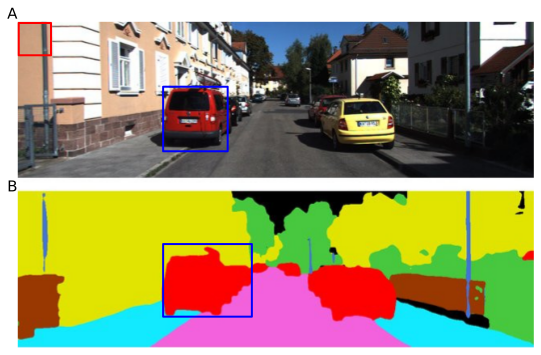

In [2]:
fig, ax = plt.subplots(figsize=(10, 6))
img=plt.imread('./data/img/semseg.jpg')
ax.imshow(img)
ax.set_axis_off()
ax.text(-0.02, 1, "A", va='bottom', transform=ax.transAxes, fontsize=15)
ax.text(-0.02, .47, "B", va='bottom', transform=ax.transAxes, fontsize=15)
ax.add_artist(Rectangle((1, 1), 40, 40, fc='none', ec='r', lw=2))
ax.add_artist(Rectangle((180, 80), 80, 80, fc='none', ec='b', lw=2))
ax.add_artist(Rectangle((180, 275), 110, 90, fc='none', ec='b', lw=2));

<i id="fig:semseg">An example of a very precise semantic segmentation (B) achieved using 3D-data from a Lidar and a video feed from a moving car (A). In a classic sliding window approach (convolutional or not) most of the windows will contain uninteresting data (red bounding box), while only some areas will actually contain an object (blue bounding box)</i>

This method hugely reduces the number of analyzed windows compared to running a sliding window algorithm (even convolutional), however it is still rather slow and there has been much work to create faster region proposal algorithms:

* The [R-CNN](https://arxiv.org/abs/1311.2524) propose regions and classify each region on at a time. It produce the output label and a bounding box. In fact R-CNN doesn't trust the bounding box that it is provided with and instead tries to define its own. Its downside is that it is slow and computationally heavy
* [Fast R-CNN](https://arxiv.org/abs/1504.08083) is a faster implementation of the R-CNN algorithm that also propose regions but, contrary to the classic R-CNN method, uses a convolutional implementation of the sliding window to classify all the proposed regions. While being faster than R-CNN, the region proposal step still is slow
* [Faster R-CNN](https://arxiv.org/pdf/1506.01497) uses convolutional implmentation of the semantic segmentation. While being significantly faster than the Fast R-CNN method, it still is slower than the YOLO algorithm.

## Semantic segmentation
A fully convolutional implementation of semantic segmentation is an idea that has evolved beyond its initial purpose of feeding regions to a bounding box prediction algorithm. Some applications require the semantic segmentation output itself: for example, for a self-driving car it may be more useful to know exactly which pixels of the image correspond to a road rather than drawing a bounding box around the road (<a href="#fig:semseg">figure above</a>). Another field that benefits from semantic segmentation is medical images (e.g. X-ray, MRI) analysis, which can detect irregularities and detect disorders.

In semantic segmentation you have per-pixel class labels. Suppose you want to be able to detect the region of a picture occupied by a car, you would have just to labels: $1$ for the car and $0$ for the background. in this case the task of the segmentation algorithm would be to output either 1 or 0 for every pixel (<a href="#fig:segmclasses">figure below</a>).

In [3]:
img = plt.imread('data/img/segm.jpg')
img = img[:, 100:-242]
model = pspnet_101_voc12() # load the pretrained model trained on Pascal VOC 2012 dataset
out = model.predict_segmentation(inp=img);

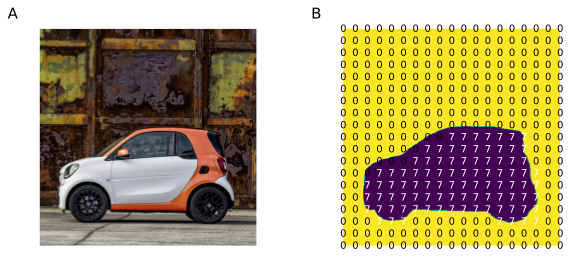

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 =axes
ax1.imshow(img)
# out.resize(out.shape[0], int(img.shape[0]*(img.shape[1]/img.shape[0])), Image.ANTIALIAS)
ax2.imshow(out*-1)
# ax2.set_aspect(np.divide(*img.shape[:-1]))

h, w = out.shape

samples = 25
outsample = out[::samples, ::samples]
for i, x in enumerate(np.linspace(0, w, outsample.shape[0])):
    for j, y in enumerate(np.linspace(0, h, outsample.shape[1])):
        obj_cls = outsample[j, i]
        ax2.text(x, y, obj_cls, va='center', ha='center', c='w' if obj_cls == 7 else 'k')

for ax, l in zip(axes, 'AB'):
    ax.text(-.1, 1.1, l, transform=ax.transAxes, fontsize=15, va='top', ha='right')
    ax.set_axis_off()

<i id="fig:segmclasses">An input picture with overlayed a sample of the per-pixel classes outputted by the pspnet segmentation algorithm (A). The full segmentation output color-coded with the car (class 7 in this model) i purple and the background (class 0) in yellow.</i>

So in a segmentation algorithm the output that we want to train the network to produce is usually a large matrix, in contrast with the relatively small output dimensions of the YOLO algorithm. In all convolutional architecture seen until now, the depth of the volume gradually increase while going deeper in the network layers and the final volume of the network usually as very small width and height. The task of a semantic segmentation network is to output very detailed localization information, so the width height of its final layer needs to have large height and width (a large resolution). To achieve this, the architecture of a semantic segmentation network has its first layers similar to a classic CONV networks, where the number of channels grow while the width and height shrink; however the volumes are then gradually upscaled and the width and height are restored to large values. To achieve this, semantic segmentation networks employ a method called **transpose convolutions**

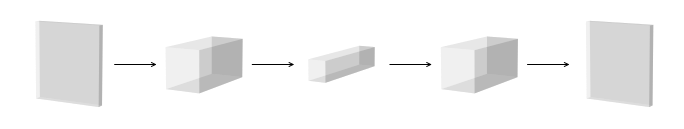

In [5]:
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 5)
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax3 = fig.add_subplot(gs[0, 2], projection='3d')
ax4 = fig.add_subplot(gs[0, 3], projection='3d')
ax5 = fig.add_subplot(gs[0, 4], projection='3d')

x, y, z = np.indices((1,1,1))
voxels = (x >= 0) & (y >= 0) & (z >= 0)

ax1.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
ax1.set_box_aspect([30, 3, 30])

ax2.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
ax2.set_box_aspect([5, 12, 5])

ax3.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
ax3.set_box_aspect([3, 16, 3])

ax4.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
ax4.set_box_aspect([5, 12, 5])

ax5.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
ax5.set_box_aspect([30, 3, 30])

plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax1.transAxes, textcoords=ax2.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax2.transAxes, textcoords=ax3.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax3.transAxes, textcoords=ax4.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax4.transAxes, textcoords=ax5.transAxes, arrowprops=dict(arrowstyle='<-'))

for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.view_init(elev=10, azim=-60)
    ax.set_axis_off()

<i id="fig:unetarch">Simplified representation of variation of volume dimensions along the layers of a semantic segmentation network. Early layers behave like a normal CONV net with the volume growing in depth while shrinking in width and height. Final layers network need to scale up the width and height of the volume to reach a sufficient resolution for the segmentation output.</i>

## Transpose convolutions
The transpose convolution is a key part of semantic segmentation architectures that is used to upscale a volume to a larger width and height. For example taking the $2 \times 2$ input in panel B of <a href="#fig:transposeconv">the figure below</a>, we can achieve a $4 \times 4$ output by applying a $3 \times 3$ filter with padding $p=1$ and stride $s=2$. Transpose convolution achieve this by mechanically applying the filter on the output instead than on the input as in classic convolution.

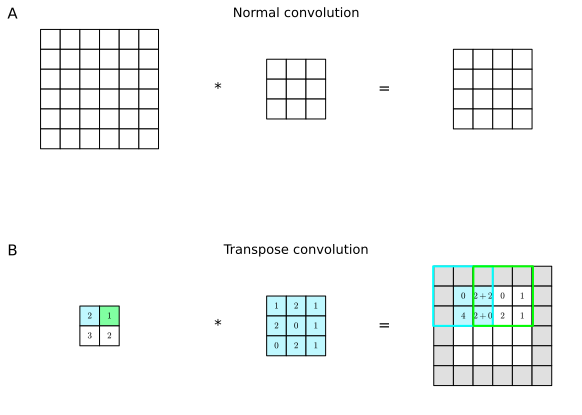

In [6]:
canvas = np.full((6, 6), '')
kernel = np.full((3, 3), '')
output = np.full((4, 4), '')

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.ravel()
fig.patch.set_visible(False)
tabs = []
tabs.append(ax1.table(canvas, loc='center', colWidths=[0.06]*6, cellLoc='center'))
tabs.append(ax2.table(kernel, loc='center', colWidths=[0.06]*6, cellLoc='center'))
tabs.append(ax3.table(output, loc='center', colWidths=[0.06]*6, cellLoc='center'))
t = ax2.text(0, 0.5, '*', va='center', ha='left', transform=ax2.transAxes, fontsize=15)
t = ax3.text(-.2, 0.5, '=', va='center', ha='left', transform=ax3.transAxes, fontsize=15)

canvas = np.array(list(map(lambda n: '${}$'.format(n), [2, 1, 3, 2]))).reshape(2, 2)
kernel = np.array(list(map(lambda n: '${}$'.format(n), [1,2,1,2,0,1,0,2,1]))).reshape(3,3)
output = np.full((6, 6), '', dtype=np.object)
output[1:3, 1:5] = [['$0$', '$2+2$', '$0$', '$1$'], ['$4$', '$2+0$', '$2$', '$1$']]
padcolor = '#e0e0e0'
filtcolor = '#bff8ff'
outcolors = colors = np.full((6, 6), padcolor, dtype=np.object)
outcolors[1:-1, 1:-1] = 'w'
outcolors[1:3, 1:3] = filtcolor
filtcolors = np.full((3, 3), filtcolor, dtype=np.object)

tabs.append(ax4.table(canvas, loc='center', colWidths=[0.06]*6, cellLoc='center', cellColours=[['#bff8ff', '#80ffa1'], ['w', 'w']]))
tabs.append(ax5.table(kernel, loc='center', colWidths=[0.06]*6, cellLoc='center', cellColours=filtcolors))
tabs.append(ax6.table(output, loc='center', colWidths=[0.06]*6, cellLoc='center', cellColours=outcolors))
t = ax5.text(0, 0.5, '*', va='center', ha='left', transform=ax5.transAxes, fontsize=15)
t = ax6.text(-.2, 0.5, '=', va='center', ha='left', transform=ax6.transAxes, fontsize=15)
ax1.text(0, 1, 'A', va='top', ha='right', transform=ax1.transAxes, fontsize=15)
plt.text(0.5, 1, 'Normal convolution', va='top', ha='center', transform=ax2.transAxes, fontsize=13)
ax4.text(0, 1, 'B', va='top', ha='right', transform=ax4.transAxes, fontsize=15)
plt.text(0.5, 1, 'Transpose convolution', va='top', ha='center', transform=ax5.transAxes, fontsize=13)
ax6.add_artist(Rectangle((-.04, 0), .04, .04, fc='none', lw=2, ec='cyan'))
ax6.add_artist(Rectangle((-.013, 0), .04, .04, fc='none', lw=2, ec='lime'))


for ax, tab in zip(axes.ravel(), tabs):
    tab.auto_set_font_size(False)
    tab.set_fontsize(9)
    tab.scale(2, 2)
    ax.axis('off')
    ax.axis('tight')
    ax.set_aspect('equal')

<i id="fig:transposeconv">The variation of dimensionality in a normal convolution that (with valid padding) reduces the width and height of the input representation (A). The variation of dimensionality of transpose convolution increases (or upscales) the width and height of the input representation (B)</i>

A single cell of the input is multiplied with the filter and this processed filter is applied to the output representation. Looking at the example in panel B of <a href="#fig:transposeconv">the figure above</a>, we can notice that with a stride $s=2$ we will have some overlapping cells at each convolutions; values resulting from overlapping portions of the filter in different steps on the transpose convolution are summed together in the final output.

Transpose convolution is not the only method to upscale a matrix, however it turns out to be the best performing in the context of semantic segmentation and especially for **U-nets**.

## U-net
In <a href="#fig:unetarch">a figure above</a>, we have seen the general architecture of a U-net, with the input volume being downscaled and then upscaled again to give an output with one channel and large values of width and height.

One modification to the architecture in <a href="#fig:unetarch">that figure</a> will vastly improve on it and turn the network in a U-net. That modification is adding skip-connection from early layers to later layers as in <a href="#fig:unetarchcomplete">figure below</a>. This way, activations from early layers (layer 1 in the figure) are directly copied to late layers (layer 3 in the figure). 

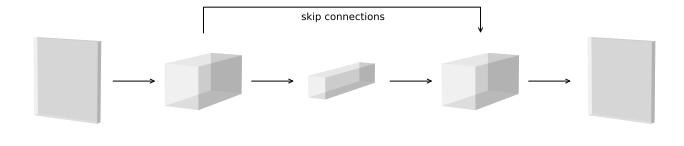

In [7]:
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 5)
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax3 = fig.add_subplot(gs[0, 2], projection='3d')
ax4 = fig.add_subplot(gs[0, 3], projection='3d')
ax5 = fig.add_subplot(gs[0, 4], projection='3d')

x, y, z = np.indices((1,1,1))
voxels = (x >= 0) & (y >= 0) & (z >= 0)

ax1.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
ax1.set_box_aspect([30, 3, 30])

ax2.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
ax2.set_box_aspect([5, 12, 5])

ax3.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
ax3.set_box_aspect([3, 16, 3])

ax4.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
ax4.set_box_aspect([5, 12, 5])

ax5.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
ax5.set_box_aspect([30, 3, 30])

plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax1.transAxes, textcoords=ax2.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax2.transAxes, textcoords=ax3.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax3.transAxes, textcoords=ax4.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax4.transAxes, textcoords=ax5.transAxes, arrowprops=dict(arrowstyle='<-'))
arr = plt.annotate('', (.5, .9), (.5, .9), xycoords=ax2.transAxes, textcoords=ax4.transAxes, 
             arrowprops=dict(arrowstyle='<-', connectionstyle='bar,armA=0,armB=0,fraction=0.1,angle=0'))
plt.annotate('skip connections', (0, 0), (0.5, .5), textcoords=arr.arrow_patch, ha='center')

for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.view_init(elev=10, azim=-60)
    ax.set_axis_off()

<i id="fig:unetarchcomplete">Typical U-net architecture</i>

The reason for U-net benefiting from skip-connections is that, for next-to-final layers to decide which regions of the representation is the object to detect, two pieces of information are useful:

* high-level spatial/contextual information provided by the immediately previous layer, which should have detected the object class in the approximate region where it is placed in the input image
* Fine-grain spatial information: since late layers have low resolution (low height and width) this is provided activations from early layers, obtained through skip-connections

More in detail the U-net architecture, whose shape looks like a U (<a></a>) hence the name, takes as input a large image with 3 channels

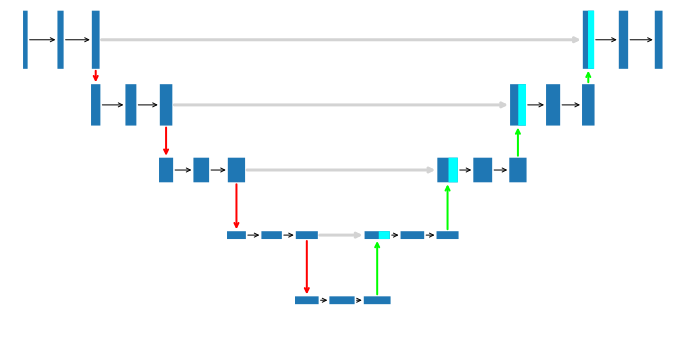

In [148]:
f = Flow(figsize=(12, 6))
vpad=4
hpad=0

nodes = []
for i in range(27):
    c='k'
    lw=1
    dst=1
    drc='e'
    if i != 1 and i % 3 == 0:
        c='r'
        lw=2
        drc = 's'
        level = -1
        fc='C0'
        if i >= 15:
            fc='none'
            c='lime'
            drc = 'n'
            level = 1
        vpad += level
        dst=1/level
    
    hpad -= level
    nodes.append(f.node(label=' '*hpad+'\n'*3*vpad,  
                        bbox=dict(boxstyle='square', fc='C0', ec='none'),
                        edge_kwargs=dict(arrowprops=dict(ec=c, lw=lw)),
                        travel=drc, distance=0.2, fontsize=5))

    
    if i >= 15:
        if i % 3 == 0:
            f.edge(nodes[i][0], nodes[((9-(i//3-1))-1)*3-1][0], arrowprops=dict(arrowstyle='->', ec='lightgray', lw=3))

vpad = 0
hpad = 5
for i in range(15, 27, 3):    
    f.node(label=' '*hpad+'\n'*3*vpad, startpoint=i+1, travel='e', distance=0.008*hpad, connect=False,
          bbox=dict(boxstyle='square', ec='none', fc='cyan'), fontsize=5)
    hpad -=1 
    vpad +=1 
    
